# **Deep Fake Detection Model Training and Testing**
In this notebook, we train the Deep-Fake models and measure machine learning metrics.

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


Paths

In [3]:
dataset_zip_path = '/content/drive/MyDrive/Final Project/Datasets/RFDS.zip'
requirements_path = '/content/drive/MyDrive/Final Project/Code Files/DeepfakeRecognition/requirements.txt'
eylon_ds = '/content/drive/MyDrive/Final Project/Datasets/experiment_ds/images.zip'
train_real_paths = '/content/RFDS/real/real_train'
val_real_paths = '/content/RFDS/real/real_val'
test_real_paths = '/content/RFDS/real/real_test'

train_fake_paths = '/content/RFDS/fake/fake_train'
val_fake_paths = '/content/RFDS/fake/fake_val'
test_fake_paths = '/content/RFDS/fake/fake_test'

weights = '/content/drive/MyDrive/Final Project/Models/DeepfakeRecognition'
train_mean_path = '/content/drive/MyDrive/Final Project/Code Files/DeepfakeRecognition/train_mean.npy'
train_std_path = '/content/drive/MyDrive/Final Project/Code Files/DeepfakeRecognition/train_std.npy'

In [4]:
!unzip '$dataset_zip_path' -d '/content/'

Streaming output truncated to the last 5000 lines.
  inflating: /content/RFDS/fake/fake_val/76-kids.-46930.png  
  inflating: /content/RFDS/fake/fake_val/158-do-de31e.png  
 extracting: /content/RFDS/fake/fake_val/229-diff--bac27.png  
  inflating: /content/RFDS/fake/fake_val/171-out-88a1b.png  
  inflating: /content/RFDS/fake/fake_val/90-Hello-e3fe1.png  
  inflating: /content/RFDS/fake/fake_val/21-gates-83c39.png  
 extracting: /content/RFDS/fake/fake_val/66-tired;-31e79.png  
  inflating: /content/RFDS/fake/fake_val/134-to-48af7.png  
 extracting: /content/RFDS/fake/fake_val/33-ways-1a319.png  
 extracting: /content/RFDS/fake/fake_val/250-energetic-e4888.png  
  inflating: /content/RFDS/fake/fake_val/119-to-0ebcb.png  
  inflating: /content/RFDS/fake/fake_val/88-great-4c2d3.png  
  inflating: /content/RFDS/fake/fake_val/222-John-e2b10.png  
 extracting: /content/RFDS/fake/fake_val/44-Kennedy-6cd94.png  
  inflating: /content/RFDS/fake/fake_val/18-be-2f6b9.png  
 extracting: /content

In [ ]:
!unzip '$eylon_ds' -d '/content/'

# Installations

In [ ]:
!pip install -r '$requirements_path'

In [ ]:
!pip install albumentations
!pip install -U git+https://github.com/albumentations-team/albumentations

# Imports

In [6]:
import numpy as np
import torch
import cv2
import torch
import torch.nn as nn
import torchvision
import random
import time
import seaborn as sns
import albumentations as A
sns.set_style("dark")

from matplotlib import pyplot as plt
from scipy import fftpack
from glob import glob
from torch.utils.data import DataLoader, Dataset
from torch.nn import functional as F
from torch import optim
from tqdm.notebook import trange
from tqdm import tqdm

# Our plotting module
import plot

gpu = torch.device('cuda')

In [7]:
%load_ext autoreload
%autoreload 2

In [8]:
AUGMENTATIONS_PATH = '/content/drive/MyDrive/Final Project/Code Files/'

In [ ]:
print(len(glob(train_fake_paths+'/*')))
print(len(glob(test_fake_paths+'/*')))
print(len(glob(val_fake_paths+'/*')))

print(len(glob(train_real_paths+'/*')))
print(len(glob(test_real_paths+'/*')))
print(len(glob(val_real_paths+'/*')))

In [ ]:
import sys
sys.path.append("/content/drive/MyDrive/Final Project/Code Files")
from final_project_augmentations import *

Plot some synthetic examples from the fake dataset after augmentations

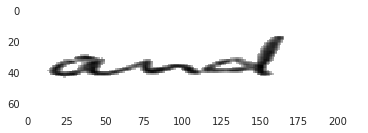

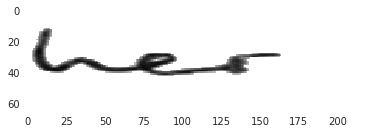

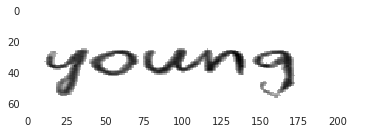

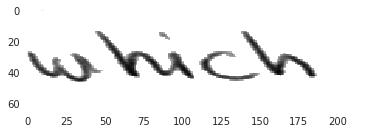

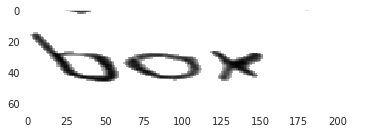

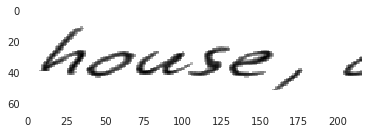

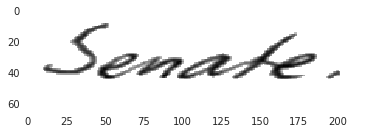

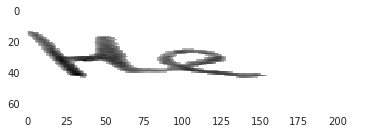

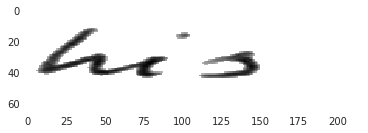

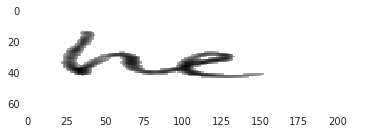

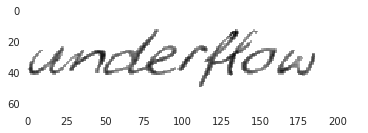

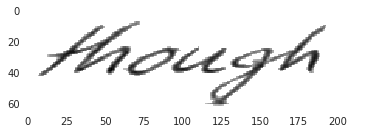

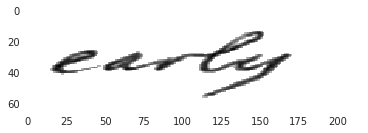

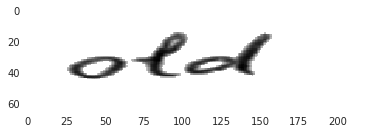

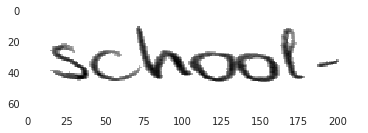

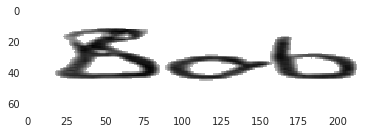

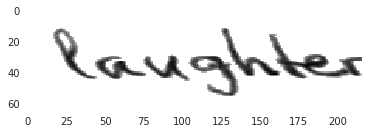

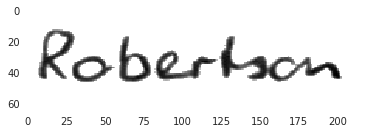

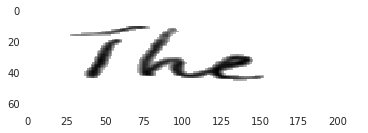

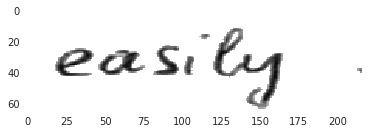

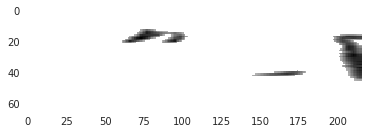

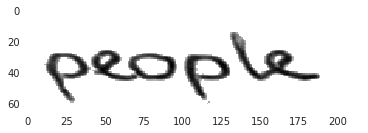

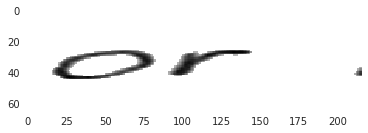

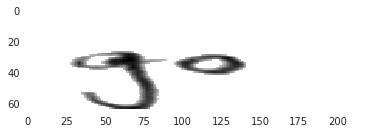

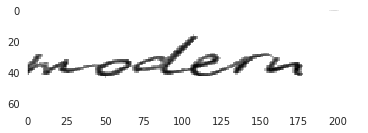

In [ ]:
lst = glob(train_fake_paths+'/*')
i = 0
for path in lst:
    pic = cv2.imread(path, 0)
    img = simple_augs(pic)
    img.shape
    plt.imshow(img, cmap='gray')
    plt.show()
    i += 1
    if i== 25:
      break

# Images are uint8 [0, 255]

In [ ]:
!wget 'https://programmer.help/images/blog/281dc6c9cb671ff48a6ef51e5a8898be.jpg'

# Apply DCT Transformation
Replicating the results from the original paper in the frequency domain of images of people before we begin

In [ ]:
celeb = plt.imread('/content/celeb.jpg')
celeb_dct = dct2_wrapper(celeb)

print(celeb.shape)
print(np.max(celeb_dct), np.min(celeb_dct))

(687, 409, 3)
11.377068675362736 -12.022055816218316


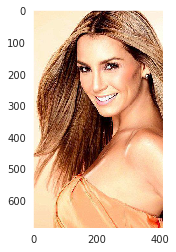

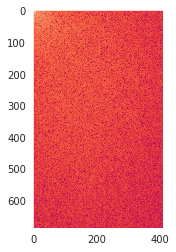

In [ ]:
plt.imshow(celeb)
plt.show()
plt.imshow(celeb_dct)
plt.show()

# Models

Frequency Domain Model

In [9]:
frequency_resnet = torchvision.models.resnet50()
frequency_resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
frequency_resnet.fc = nn.Linear(in_features=2048, out_features=2, bias=True)
frequency_resnet.to(gpu);

In [10]:
frequency_resnet.load_state_dict(torch.load(f'{weights}/deepfake_recognizer_freq_space_april19_binary.model'))
frequency_resnet.eval();

Image Domain Model

In [ ]:
image_resnet = torchvision.models.resnet50()
image_resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
image_resnet.fc = nn.Linear(in_features=2048, out_features=2, bias=True)
image_resnet.to(gpu);

In [ ]:
image_resnet.load_state_dict(torch.load(f'{weights}/deepfake_recognizer_image_space_april20_binary.model'))
image_resnet.eval();

In [ ]:
!unzip "/content/eylonhand.zip" -d "/content"

In [ ]:
train_mean = np.load(train_mean_path)
train_std = np.load(train_std_path)
print(train_mean.shape, train_std.shape)

(64, 216) (64, 216)


In [ ]:
paths = glob("/content/eylonhand/*")
lst=list()
for p in paths:
    x = cv2.imread(p, 0)
    x = simple_augs(x)
    # x = dct2_wrapper(x)
    # x = normalize(x, train_mean, train_std)
    x = torch.from_numpy(x)
    x = x.unsqueeze(0).unsqueeze(0)
    x = x.float()
    x = x.to(gpu)
    lst.append(torch.argmax(image_resnet(x)).item())

In [ ]:
print(cv2.__version__, torch.__version__, torchvision.__version__, np.__version__)

4.1.2 1.8.0+cu101 0.9.0+cu101 1.19.5


In [ ]:
fakes = len([x for x in lst if x == 1])
reals = len([x for x in lst if x == 0])
length = len(paths)

print("acc = ", reals/length)

acc =  1.0


# Data Loader

In [67]:
class Fake_Real_Handwriting_DS(Dataset):
    def __init__(self, real_paths, fake_paths, mean=None, std=None, show=False):
        super(Fake_Real_Handwriting_DS, self).__init__()
        self.show = show
        self.real_base_name = real_paths[0].split('/')[-3]
        self.fake_base_name = fake_paths[0].split('/')[-3]
        min_len = min(len(fake_paths), len(real_paths))

        self.paths = real_paths[0:min_len] + fake_paths[0:min_len]
        random.shuffle(self.paths)
        self.mean, self.std = mean, std

        print(f"Real Base Name: {self.real_base_name}")
        print(f"Fake Base Name: {self.fake_base_name}")

    def __getitem__(self, idx):
        p = self.paths[idx]
        x = None
        try:
            x = plt.imread(p)
            x = cv2.resize(x, (100, 50))
            x = simple_augs(x)
            if self.show:
                x2 = x.copy()
                x2 = torch.from_numpy(x2).float()
            x = dct2_wrapper(x)
            # if self.mean is not None and self.std is not None:
            #     x = normalize(x, self.mean, self.std)
            # plt.imshow(x)
            x = torch.from_numpy(x)
            x = x.unsqueeze(0)
            x = x.float()
            y = 0 if p.split("/")[-3] == self.real_base_name else 1
            # print(y[0])
            if self.show:
                return x, x2, y
            return x, y
        except Exception:
            return self.__getitem__(idx+1)

    def __len__(self):
        return len(self.paths)

# Calculate mean and std with respect to the train set

In [ ]:

train_paths = glob(f'{train_real_paths}/*.png') + glob(f'{train_fake_paths}/*.png')
train_set = list()
for i in trange(len(train_paths)):
    train_set.append(dct2_wrapper(cv2.imread(train_paths[i], 0)))

print(len(train_set))


59998


In [ ]:
random.shuffle(train_set)
train_mean, train_var = welford(train_set)
train_std = np.sqrt(train_var)

# Save values
np.save(train_mean_path, train_mean)
np.save(train_std_path, train_std)

# Load train_mean and train_std if necessary

In [ ]:
train_mean = np.load(train_mean_path)
train_std = np.load(train_std_path)
print(train_mean.shape, train_std.shape)

(64, 216) (64, 216)


In [46]:
train_mean = None
train_std = None

In [68]:
train_ds = Fake_Real_Handwriting_DS(glob(f'{train_real_paths}/*.png'), glob(f'{train_fake_paths}/*.png'), train_mean, train_std)
train_dl = DataLoader(train_ds, 64, num_workers=2)

val_ds = Fake_Real_Handwriting_DS(glob(f'{val_real_paths}/*.png'), glob(f'{val_fake_paths}/*.png'), train_mean, train_std)
val_dl = DataLoader(val_ds, 64, num_workers=2)

test_ds = Fake_Real_Handwriting_DS(glob(f'{test_real_paths}/*.png'), glob(f'{test_fake_paths}/*.png'), train_mean, train_std, show=True)
test_dl = DataLoader(test_ds, 64, num_workers=2)

Real Base Name: real
Fake Base Name: fake
Real Base Name: real
Fake Base Name: fake
Real Base Name: real
Fake Base Name: fake


In [61]:
print(len(test_ds), len(val_ds), len(train_ds))

10446 10804 85962


tensor(0)


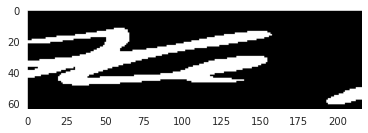

tensor(1)


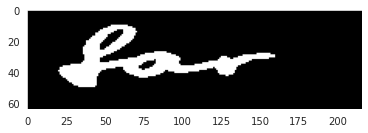

tensor(1)


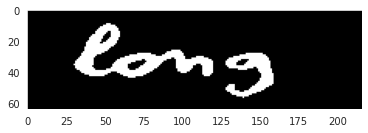

tensor(0)


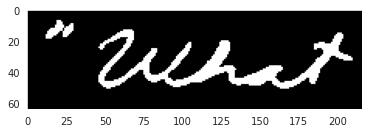

tensor(1)


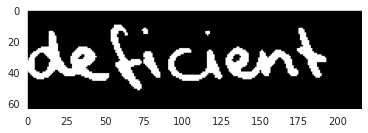

tensor(0)


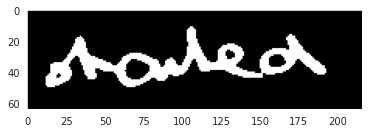

tensor(1)


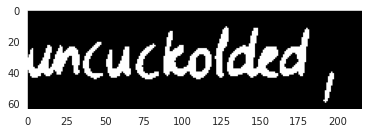

tensor(1)


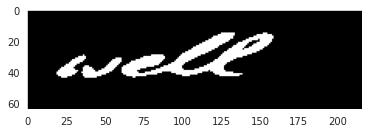

tensor(1)


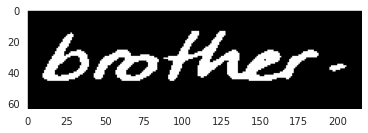

tensor(0)


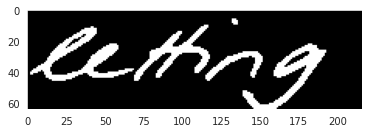

In [ ]:
i = 10
for x, y in test_dl:
    print(y[0])
    plt.imshow(x[0][0], cmap='gray')
    plt.show()
    i -= 1
    if i <=0:
      break 

# Machine Learning Metric functions

In [15]:
def batch_stats(preds, wids):
    tp = 0
    tn = 0
    fp = 0
    fn = 0 
    softmax = nn.Softmax(dim=0)
    for pred, wid in zip(preds, wids):
        pred = softmax(pred)
        pred = torch.argmax(pred)
        if pred == wid.item() and pred == 1:
            tp +=1
        elif pred == wid.item() and pred == 0:
            tn += 1
        elif pred != wid.item() and pred == 1:
            fp +=1
        elif pred != wid.item() and pred == 0:
            fn += 1
    return tp, tn, fp, fn

def get_all_metrics(model, dataloader, device, alpha=0.5):
    model.eval()
    TP, TN, FP, FN = 0, 0, 0, 0
    exp = 0.0000001
    for x, y in tqdm(dataloader):
        x = x.to(device)
        y = y.to(device)
        tp, tn, fp, fn = batch_stats(model(x), y)
        TP += tp
        TN += tn
        FP += fp
        FN += fn
    acc = (TP + TN) / (TP + TN + FP + FN + exp)
    precision = TP / (TP + FP + exp)
    recall = TP / (TP + FN + exp)
    f_measure = alpha * precision + (1-alpha) * recall
    print(f"\nTP={TP}\nTN={TN}\nFP={FP}\nFN={FN}")
    print(f"\nAccuracy={acc}\nPrecision={precision}\nRecall={recall}\nF_Measure={f_measure}")
    return acc, precision, recall, f_measure

def write_metrics_to_file(f, TP, TN, FP, FN):
    alpha = 0.5
    exp = 0.0000001
    acc = (TP + TN) / (TP + TN + FP + FN + exp)
    precision = TP / (TP + FP + exp)
    recall = TP / (TP + FN + exp)
    f_measure = (alpha * precision + (1-alpha) * recall)
    f.write(f"{str(acc)[0:7]} {str(precision)[0:7]} {str(recall)[0:7]} {str(f_measure)[0:7]}\n")

Main Training Function

In [ ]:
def train(train_loader, val_loader, model, opt, sched, f=None, epoch=0, loss=nn.CrossEntropyLoss()):
    global gpu
    model.train()
    time_s = time.time()
    l = 0
    loss_lst = list()
    for x, y in train_loader:
        x = x.to(gpu)
        y = y.to(gpu)
        opt.zero_grad()
        pred = model(x)
        tp, tn, fp, fn = batch_stats(pred, y)
        write_metrics_to_file(f, tp, tn, fp, fn)
        l = loss(pred, y)
        l.backward()
        opt.step()
        loss_lst.append(l.detach().item())

    sched.step()

    train_metrics = get_all_metrics(model, train_loader, gpu)
    val_metrics = get_all_metrics(model, val_loader, gpu)

    print(f"Epoch {epoch}, Loss = {l}, Train Accuracy = {train_metrics[0]}, Validation Accuracy = {val_metrics[0]}")
    return loss_lst, train_metrics, val_metrics


def main(train_loader, val_loader, model, epochs=1):
    metric_file_path = "/content/drive/MyDrive/Final Project/Code Files/DeepfakeRecognition/image_space_deepfake_metrics_binary.txt"
    with open(metric_file_path, "w") as f:
        params = list(model.parameters())
        opt = optim.Adam([p for p in params if p.requires_grad], lr=0.01)
        sched = optim.lr_scheduler.CosineAnnealingLR(opt, epochs, eta_min=0, last_epoch=-1)
        loss_lst, acc_lst, precision_lst, recall_lst, f_measure_lst = [], [], [], [], []

        val_acc_lst, val_precision_lst, val_recall_lst, val_f_measure_lst = [], [], [], []
        
        for epoch in trange(1, epochs):
            epoch_loss_lst, train_metrics, val_metrics = train(train_loader, val_loader, model, opt, sched, f=f, epoch=epoch)
            loss_lst += epoch_loss_lst

            acc_lst.append(train_metrics[0])
            precision_lst.append(train_metrics[1])
            recall_lst.append(train_metrics[2])
            f_measure_lst.append(train_metrics[3])

            val_acc_lst.append(val_metrics[0])
            val_precision_lst.append(val_metrics[1])
            val_recall_lst.append(val_metrics[2])
            val_f_measure_lst.append(val_metrics[3])

    return loss_lst, acc_lst, precision_lst, recall_lst, f_measure_lst, val_acc_lst, val_precision_lst, val_recall_lst, val_f_measure_lst

# Calculate pixel histogram

# Frequence Space training

In [ ]:
try:
    loss_lst, acc_lst, precision_lst, recall_lst, f_measure_lst, val_acc_lst, val_precision_lst, val_recall_lst, val_f_measure_lst = main(train_dl, val_dl, frequency_resnet, 10)
except Exception as e:
    print(e)
finally:
    torch.save(frequency_resnet.state_dict(), f'{weights}/deepfake_recognizer_freq_space_april19_binary.model')

Save metrics into a file for later analysis

In [ ]:
metric_file_path = "/content/drive/MyDrive/Final Project/Code Files/DeepfakeRecognition/freq_deepfake_loss_binary.txt"
with open(metric_file_path, "w") as f2:
    for l in loss_lst:
      f2.write(f"{l}\n")

In [ ]:
metric_file_path = "/content/drive/MyDrive/Final Project/Code Files/DeepfakeRecognition/freq_deepfake_val_metrics_binary.txt"
with open(metric_file_path, "w") as f2:
    for i in range(len(val_acc_lst)):
      f2.write(f"{str(val_acc_lst[i])[0:7]} {str(val_precision_lst[i])[0:7]} {str(val_recall_lst[i])[0:7]} {str(val_f_measure_lst[i])[0:7]}\n")

# Testing the Frequency Domain Model

In [16]:
names = ["Accuracy", "Precision", "Recall", "F1"]

* Training Metrics

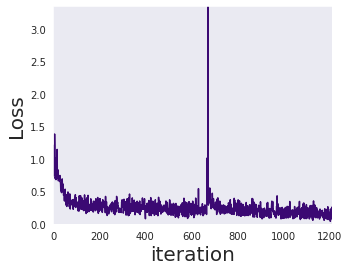

In [36]:
stats_path = "/content/drive/MyDrive/Final Project/Code Files/DeepfakeRecognition/freq_deepfake_loss_binary.txt"
plot.plot_stats(stats_path, ["Loss"], size_per_col=4, size_per_row=5, fontsize=20, sampling_timestamp=10, ncols=1)

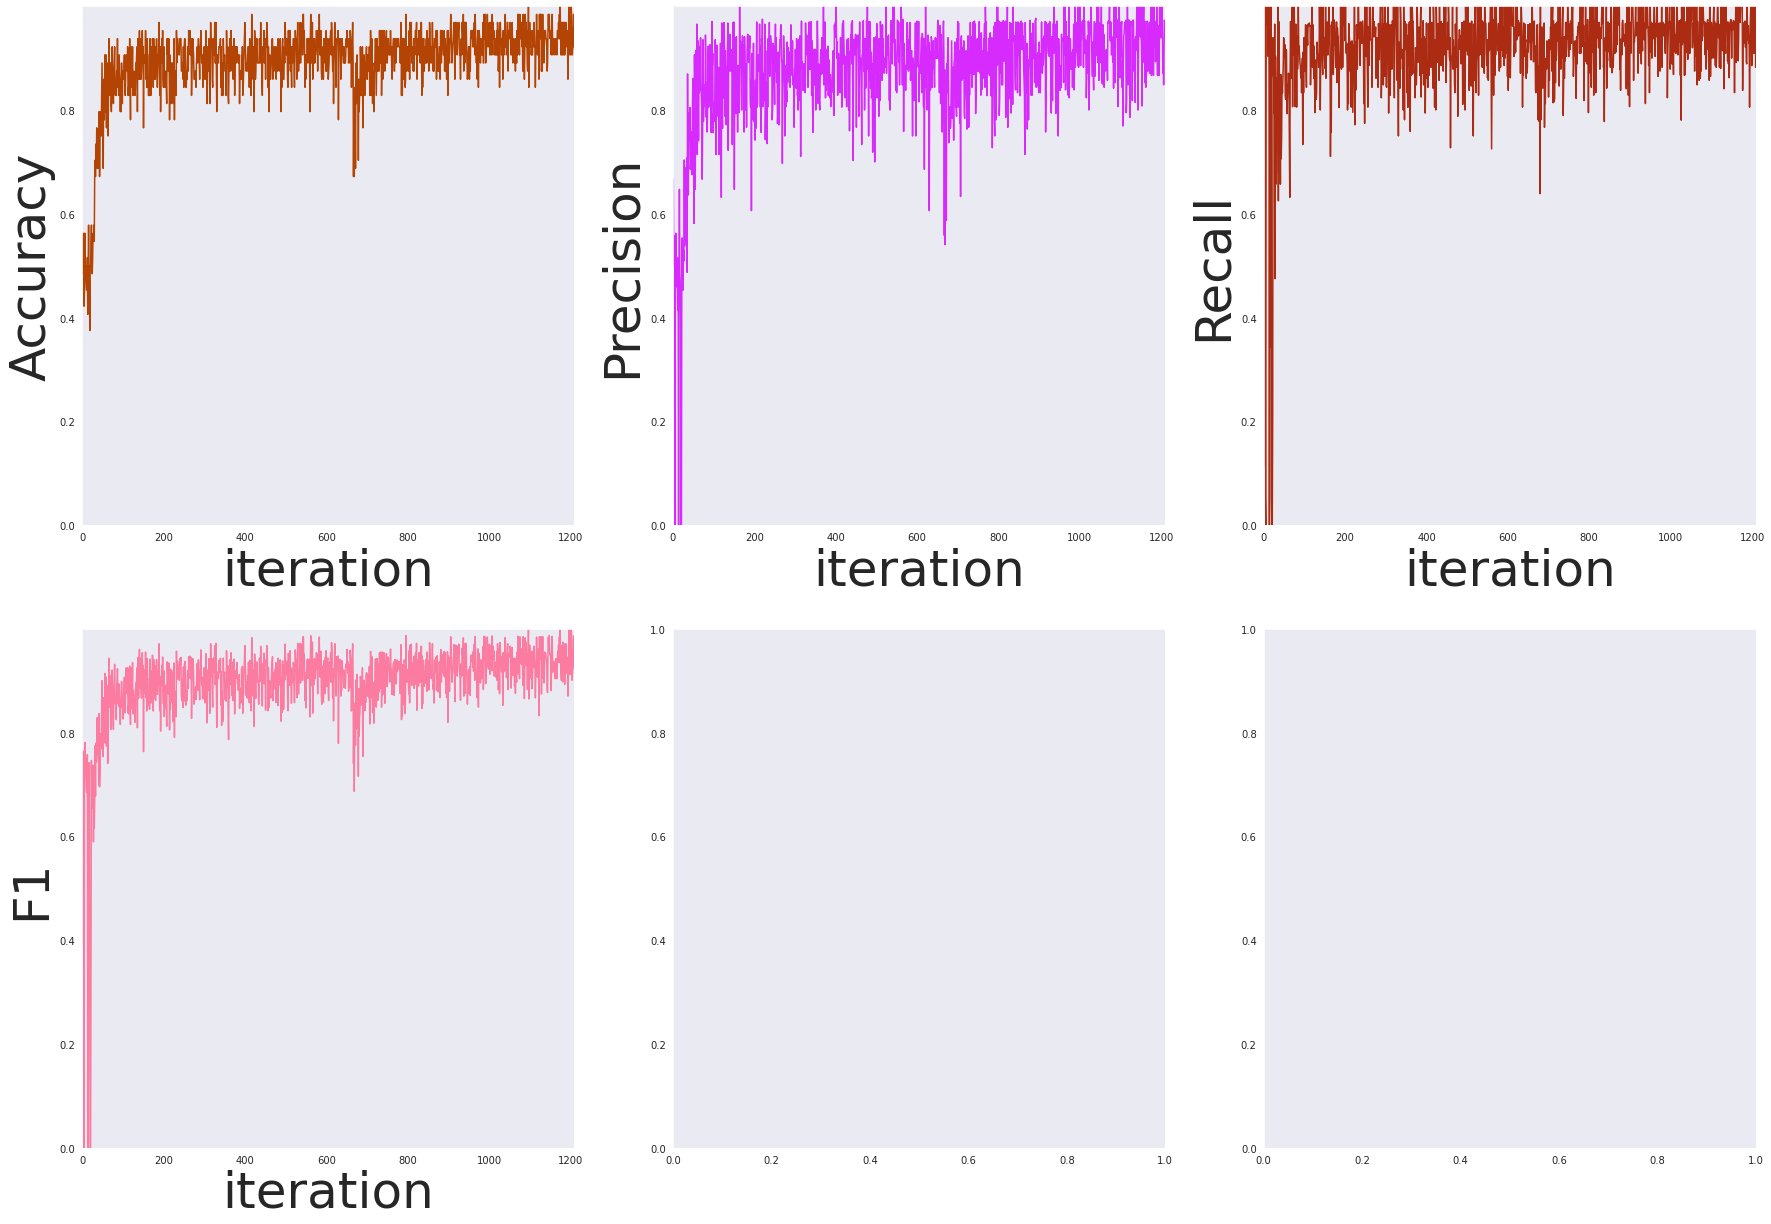

In [21]:
stats_path = "/content/drive/MyDrive/Final Project/Code Files/DeepfakeRecognition/freq_deepfake_metrics_binary.txt"
plot.plot_stats(stats_path, names, size_per_col=7, sampling_timestamp=10)

* Validation / Test Metrics

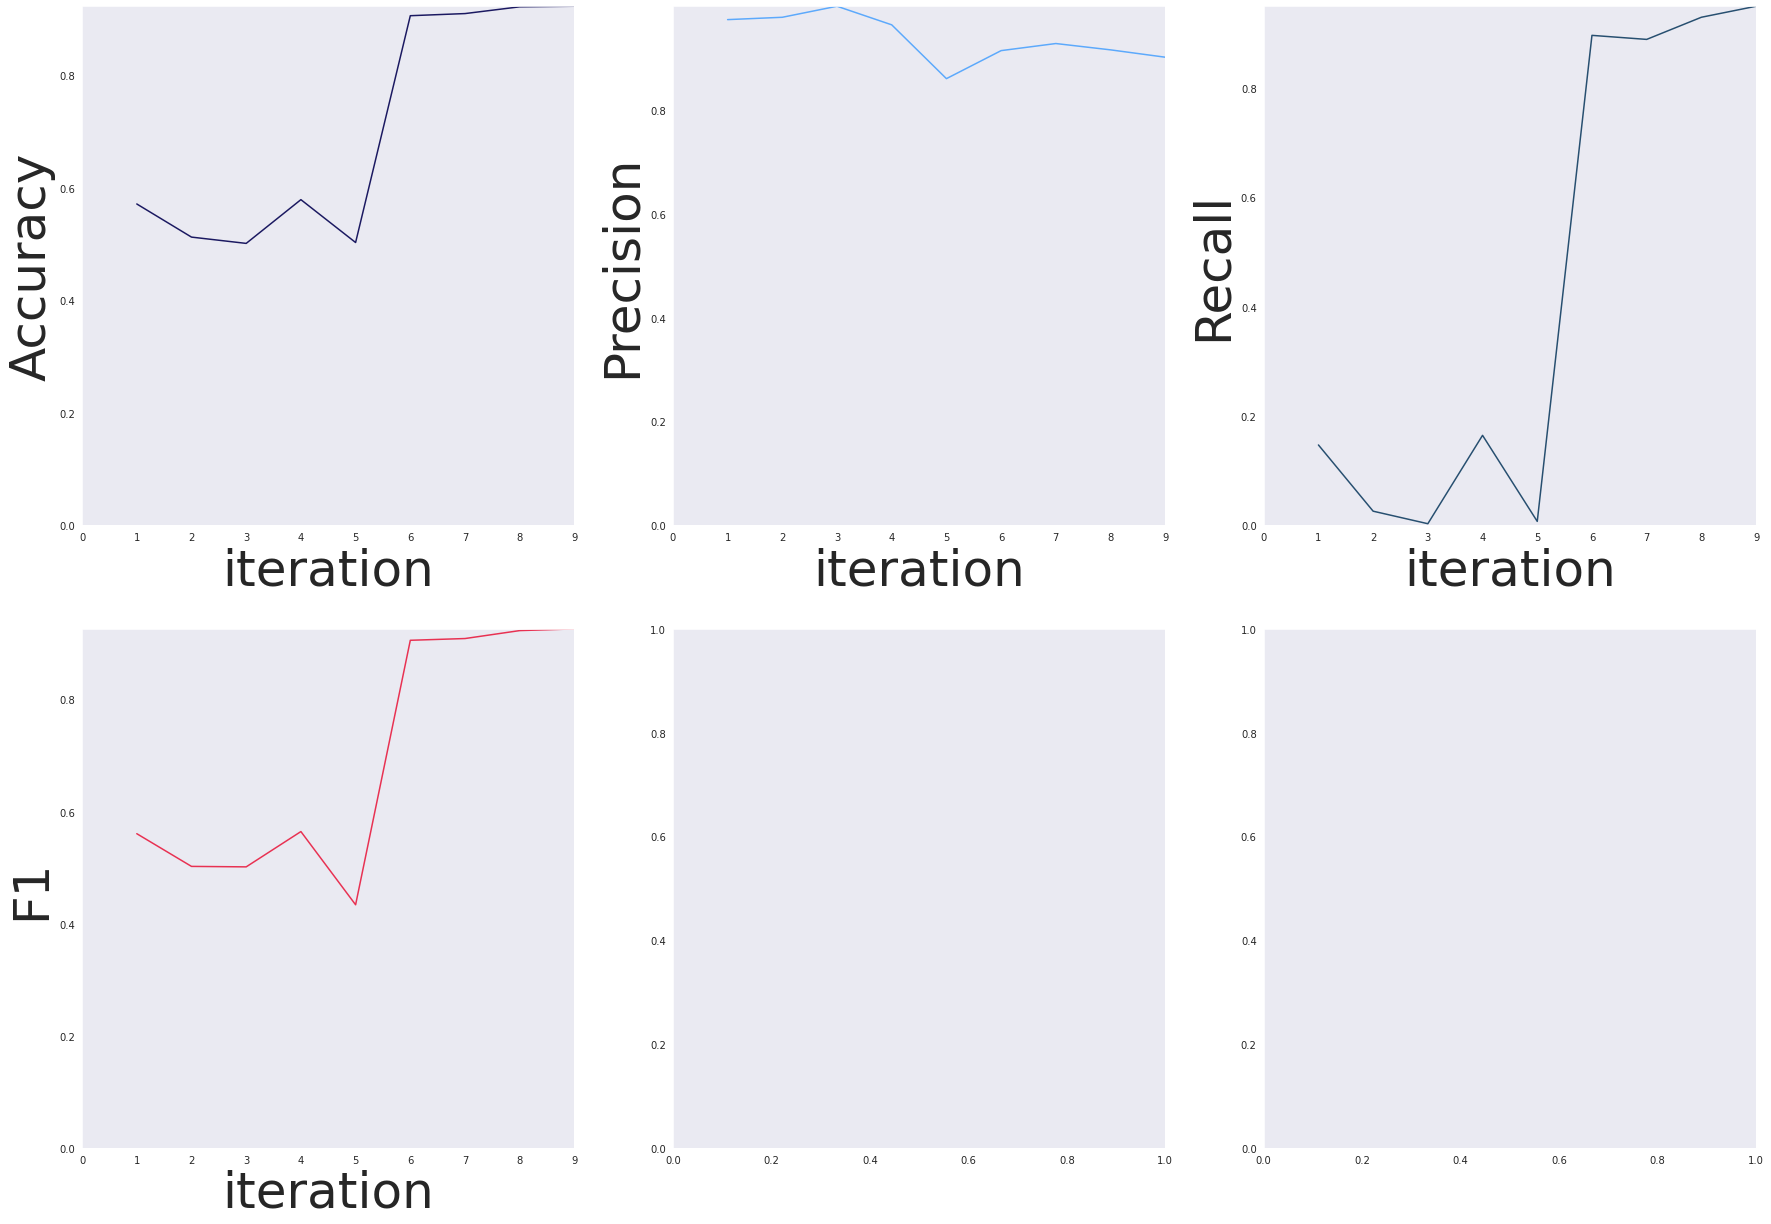

In [23]:
stats_path = "/content/drive/MyDrive/Final Project/Code Files/DeepfakeRecognition/freq_deepfake_val_metrics_binary.txt"
plot.plot_stats(stats_path, names, size_per_col=7)

# Image Space training

In [ ]:
loss_lst, acc_lst, precision_lst, recall_lst, f_measure_lst, val_acc_lst, val_precision_lst, val_recall_lst, val_f_measure_lst = list(), list(), list(), list(), list(), list(), list(), list(), list()

try:
    loss_lst, acc_lst, precision_lst, recall_lst, f_measure_lst, val_acc_lst, val_precision_lst, val_recall_lst, val_f_measure_lst = main(train_dl, val_dl, image_resnet, 8)
except Exception as e:
    print(e)
finally:
    torch.save(image_resnet.state_dict(), f'{weights}/deepfake_recognizer_image_space_april20_binary.model')
    metric_file_path = "/content/drive/MyDrive/Final Project/Code Files/DeepfakeRecognition/image_space_deepfake_loss_binary.txt"
    with open(metric_file_path, "w") as f2:
        for l in loss_lst:
          f2.write(f"{l}\n")
    metric_file_path = "/content/drive/MyDrive/Final Project/Code Files/DeepfakeRecognition/image_space_deepfake_val_metrics_binary.txt"
    with open(metric_file_path, "w") as f2:
        for i in range(len(val_acc_lst)):
          f2.write(f"{str(val_acc_lst[i])[0:7]} {str(val_precision_lst[i])[0:7]} {str(val_recall_lst[i])[0:7]} {str(val_f_measure_lst[i])[0:7]}\n")

In [ ]:
metric_file_path = "/content/drive/MyDrive/Final Project/Code Files/DeepfakeRecognition/image_space_deepfake_loss_binary.txt"
with open(metric_file_path, "w") as f2:
    for l in loss_lst:
      f2.write(f"{l}\n")

In [ ]:
metric_file_path = "/content/drive/MyDrive/Final Project/Code Files/DeepfakeRecognition/freq_deepfake_val_metrics.txt"
with open(metric_file_path, "w") as f2:
    for i in range(len(val_acc_lst)):
      f2.write(f"{str(val_acc_lst[i])[0:7]} {str(val_precision_lst[i])[0:7]} {str(val_recall_lst[i])[0:7]} {str(val_f_measure_lst[i])[0:7]}\n")

In [ ]:
loss      = [loss_lst[i] for i in range(len(loss_lst)) if i % 5 == 0]
train_acc = [acc_lst[i] for i in range(len(acc_lst))]
val_acc   = [val_acc_list[i] for i in range(len(val_acc_list))]
plt.plot(loss, color='r')
plt.show()
plt.plot(train_acc, color='b')
plt.plot(val_acc, color='g')
plt.show()

# Testing the image space model on test images from different distribution

In [ ]:
!unzip "/content/fakes_cropped_encodedbywhatsapp.zip" -d "/content"

In [ ]:
paths = glob("/content/fakes_cropped_encodedbywhatsapp/*")
lst=list()
for p in tqdm(paths):
    x = cv2.imread(p, 0)
    x = simple_augs(x)
    x = torch.from_numpy(x)
    x = x.unsqueeze(0).unsqueeze(0)
    x = x.float()
    x = x.to(gpu)
    lst.append(torch.argmax(frequency_resnet(x)).item())

100%|██████████| 849/849 [00:11<00:00, 73.29it/s]


In [ ]:
fakes = len([x for x in lst if x == 1])
reals = len([x for x in lst if x == 0])
length = len(paths)

print("acc = ", fakes/length)
print(lst)

acc =  0.9151943462897526
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1

# Testing the image space model

In [ ]:
names = ["Accuracy", "Precision", "Recall", "F1"]

* Training Metrics

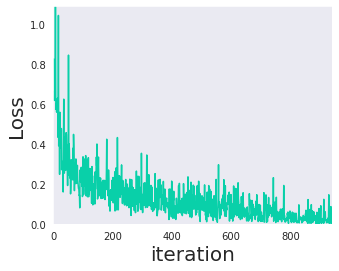

In [37]:
stats_path = "/content/drive/MyDrive/Final Project/Code Files/DeepfakeRecognition/image_space_deepfake_loss_binary.txt"
plot.plot_stats(stats_path, ["Loss"], size_per_col=4, size_per_row=5, fontsize=20, sampling_timestamp=10, ncols=1)

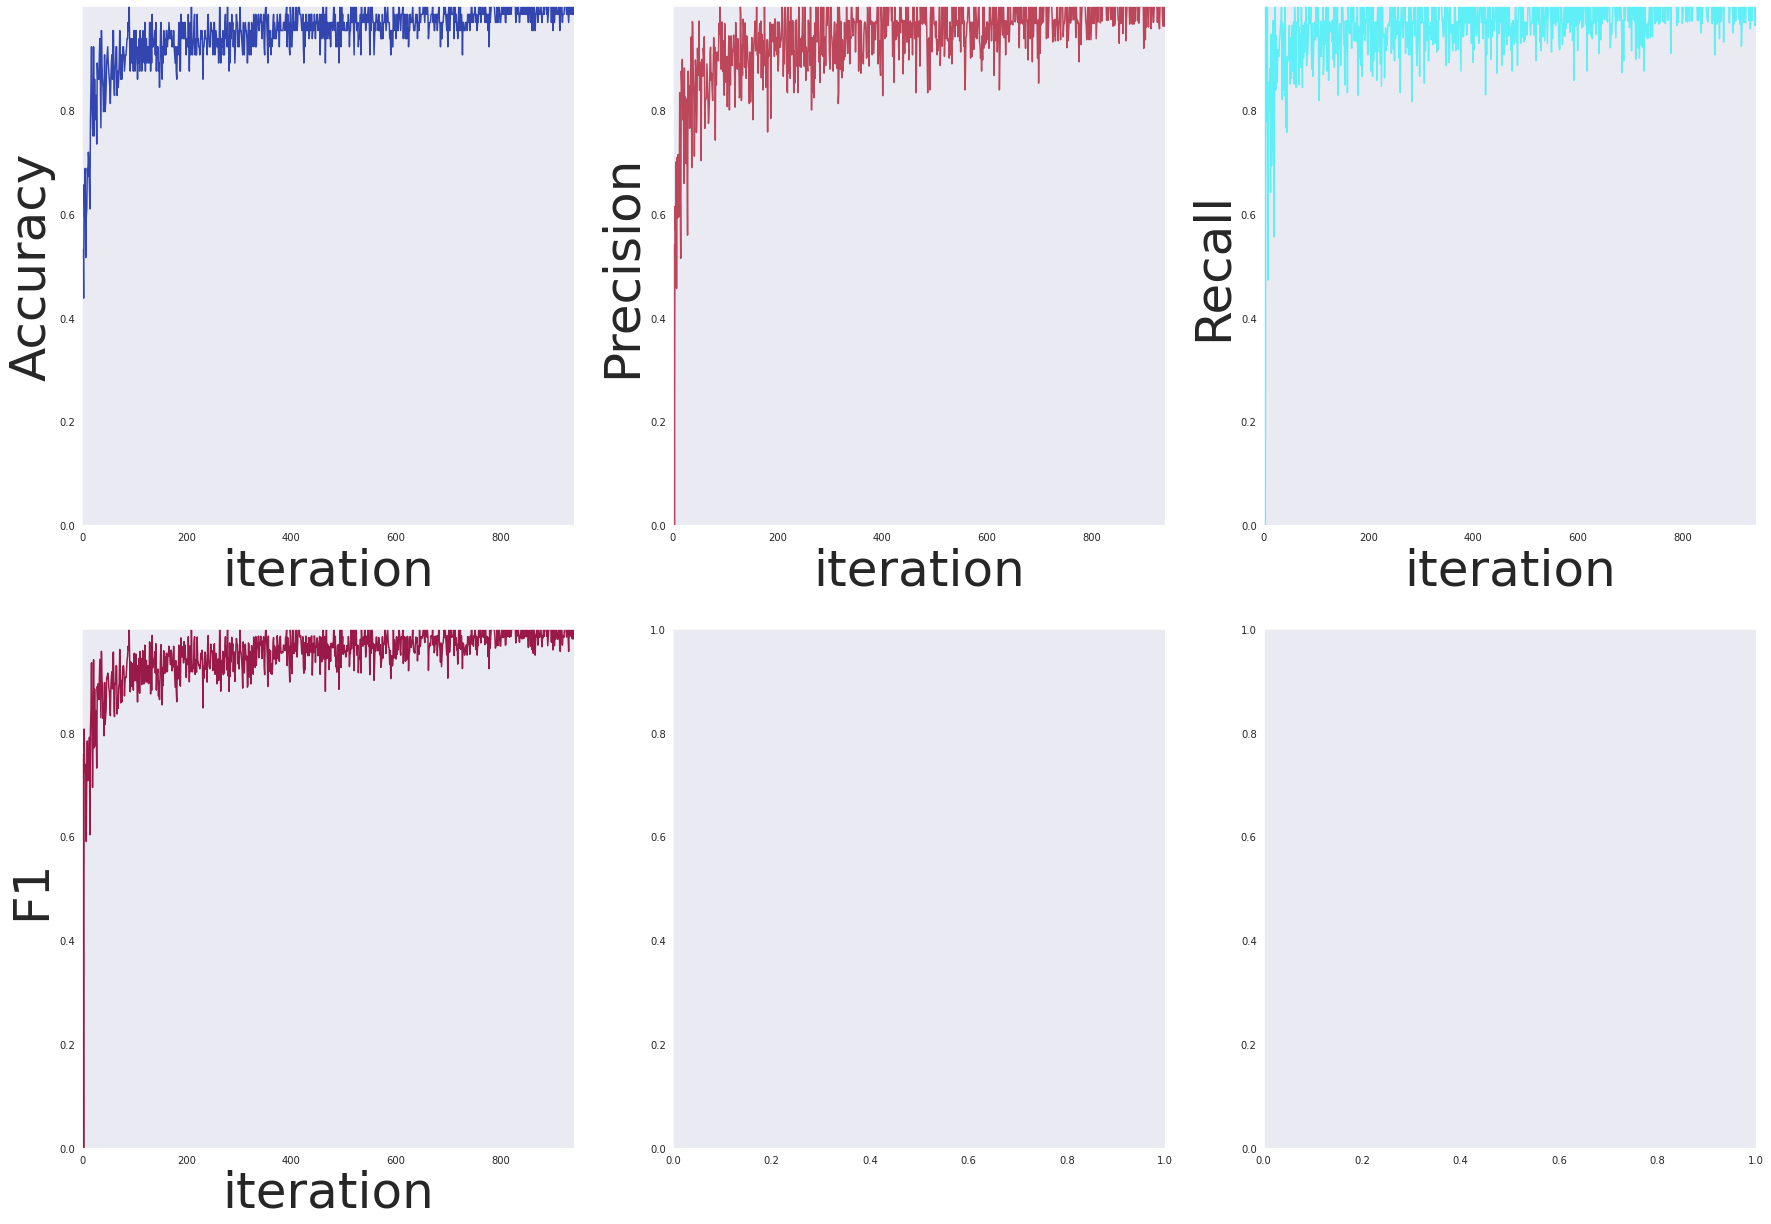

In [72]:
stats_path = "/content/drive/MyDrive/Final Project/Code Files/DeepfakeRecognition/image_space_deepfake_metrics_binary.txt"
plot.plot_stats(stats_path, names, size_per_col=7, sampling_timestamp=10)

* Validation / Test Metrics

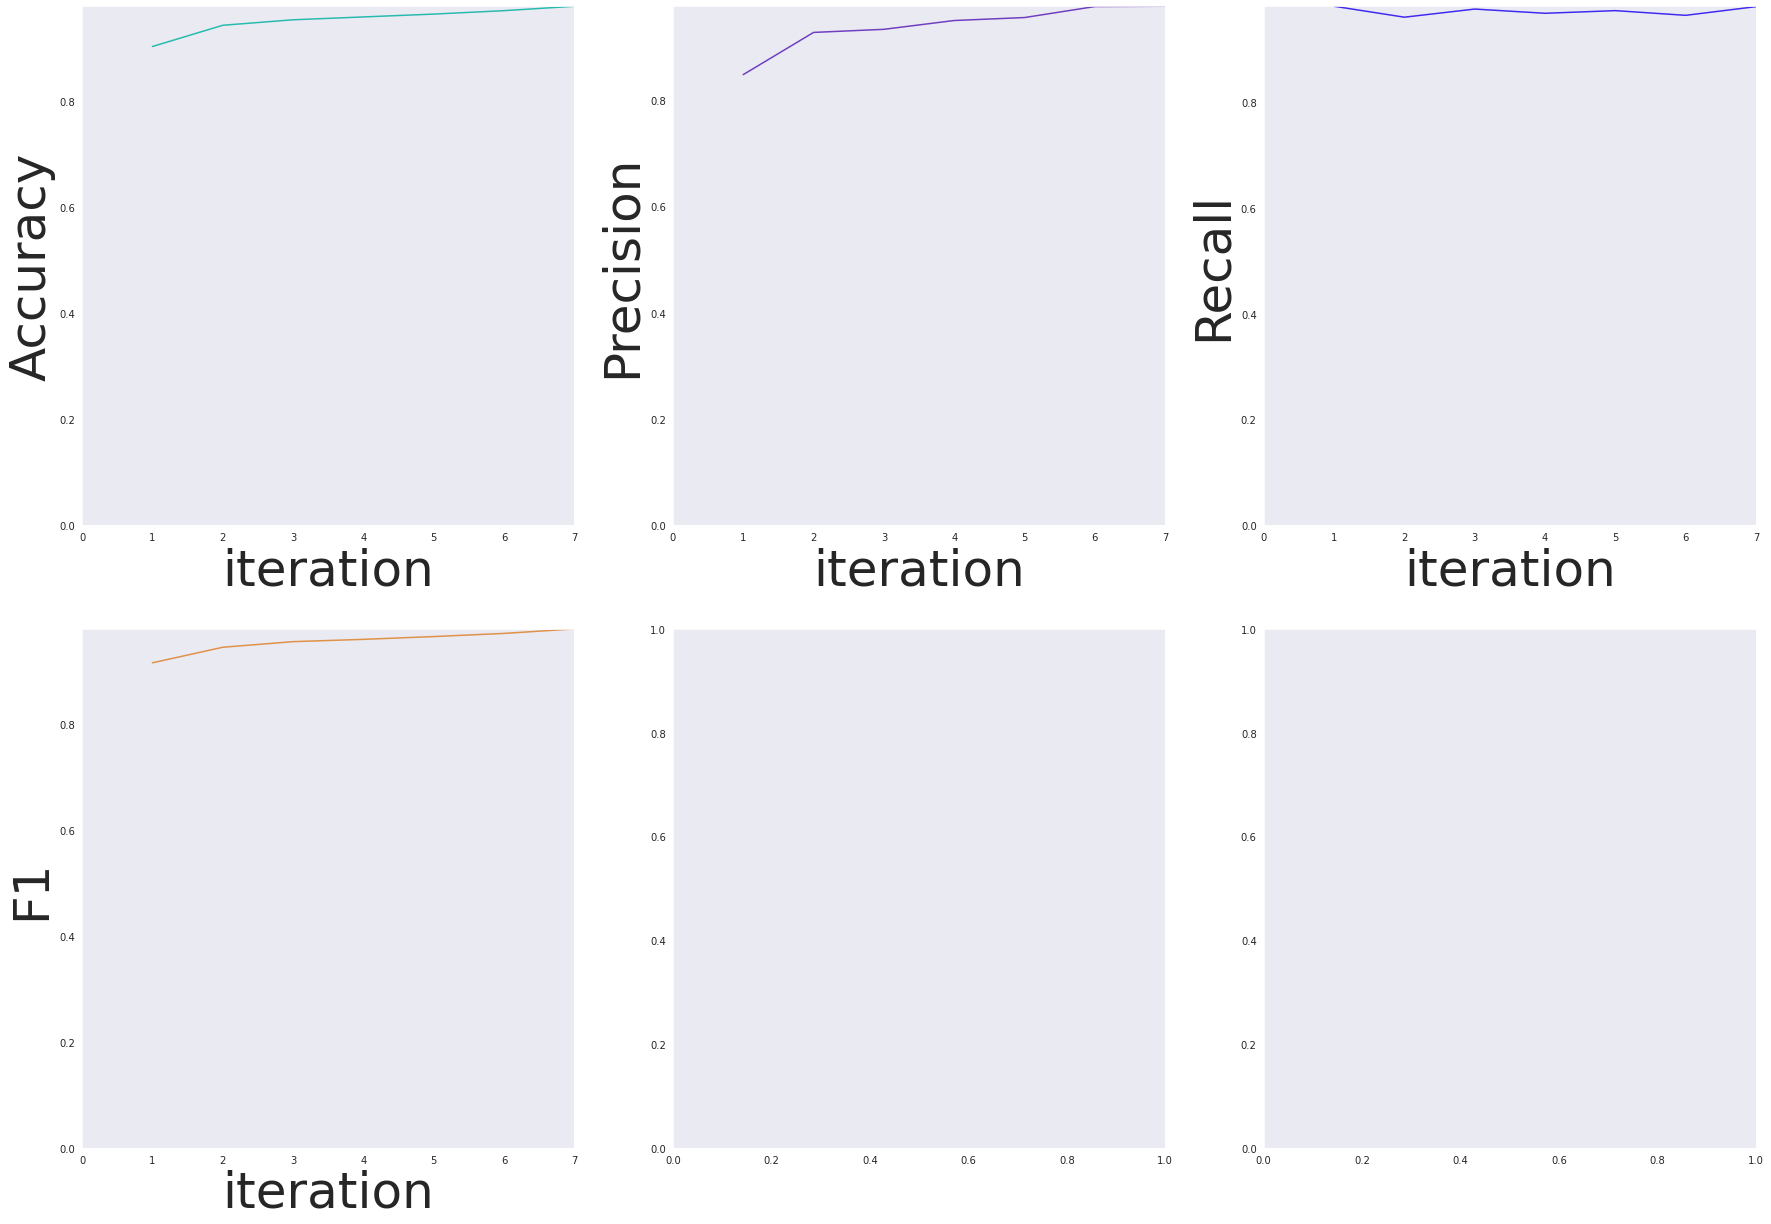

In [76]:
stats_path = "/content/drive/MyDrive/Final Project/Code Files/DeepfakeRecognition/image_space_deepfake_val_metrics_binary.txt"
plot.plot_stats(stats_path, names, size_per_col=7)

# Feature maps visualization

Collecting the all of the convolutional layers of the image space model

In [ ]:
no_of_layers=0
conv_layers=[image_resnet.conv1]

for bottleneck in image_resnet.layer1:
    sublayers = list(bottleneck.children())
    for layer in sublayers:
      if type(layer)==nn.Conv2d:
          no_of_layers+=1
          conv_layers.append(layer)
      elif type(layer)==nn.Sequential:
          for child in layer:
            if type(child)==nn.Conv2d:
                no_of_layers+=1
                conv_layers.append(child)

for bottleneck in image_resnet.layer2:
    sublayers = list(bottleneck.children())
    for layer in sublayers:
      if type(layer)==nn.Conv2d:
          no_of_layers+=1
          conv_layers.append(child)
      elif type(layer)==nn.Sequential:
          for child in layer:
            if type(child)==nn.Conv2d:
                no_of_layers+=1
                conv_layers.append(child)

for bottleneck in image_resnet.layer3:
    sublayers = list(bottleneck.children())
    for layer in sublayers:
      if type(layer)==nn.Conv2d:
          no_of_layers+=1
          conv_layers.append(child)
      elif type(layer)==nn.Sequential:
          for child in layer:
            if type(child)==nn.Conv2d:
                no_of_layers+=1
                conv_layers.append(child)

for bottleneck in image_resnet.layer4:
    sublayers = list(bottleneck.children())
    for layer in sublayers:
      if type(layer)==nn.Conv2d:
          no_of_layers+=1
          conv_layers.append(child)
      elif type(layer)==nn.Sequential:
          for child in layer:
            if type(child)==nn.Conv2d:
                no_of_layers+=1
                conv_layers.append(child)

print(no_of_layers)

52


In [ ]:
image_resnet = image_resnet.to("cpu") 
model_weights = []
conv_layers = []
# get all the model children as list
model_children = list(image_resnet.children())

Filtering to get the convolutional layers only

In [ ]:
# counter to keep count of the conv layers
counter = 0 
# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolutional layers: {counter}")

Total convolutional layers: 49


In [ ]:
# take a look at the conv layers and the respective weights
for weight, conv in zip(model_weights, conv_layers):
    # print(f"WEIGHT: {weight} \nSHAPE: {weight.shape}")
    print(f"CONV: {conv} ====> SHAPE: {weight.shape}")

CONV: Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) ====> SHAPE: torch.Size([64, 1, 7, 7])
CONV: Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False) ====> SHAPE: torch.Size([64, 64, 1, 1])
CONV: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) ====> SHAPE: torch.Size([64, 64, 3, 3])
CONV: Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False) ====> SHAPE: torch.Size([256, 64, 1, 1])
CONV: Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False) ====> SHAPE: torch.Size([64, 256, 1, 1])
CONV: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) ====> SHAPE: torch.Size([64, 64, 3, 3])
CONV: Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False) ====> SHAPE: torch.Size([256, 64, 1, 1])
CONV: Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False) ====> SHAPE: torch.Size([64, 256, 1, 1])
CONV: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False

CONV: Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) ====> SHAPE: torch.Size([64, 1, 7, 7])
CONV: Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False) ====> SHAPE: torch.Size([64, 64, 1, 1])
CONV: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) ====> SHAPE: torch.Size([64, 64, 3, 3])
CONV: Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False) ====> SHAPE: torch.Size([256, 64, 1, 1])
CONV: Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False) ====> SHAPE: torch.Size([64, 256, 1, 1])
CONV: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) ====> SHAPE: torch.Size([64, 64, 3, 3])
CONV: Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False) ====> SHAPE: torch.Size([256, 64, 1, 1])
CONV: Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False) ====> SHAPE: torch.Size([64, 256, 1, 1])
CONV: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False

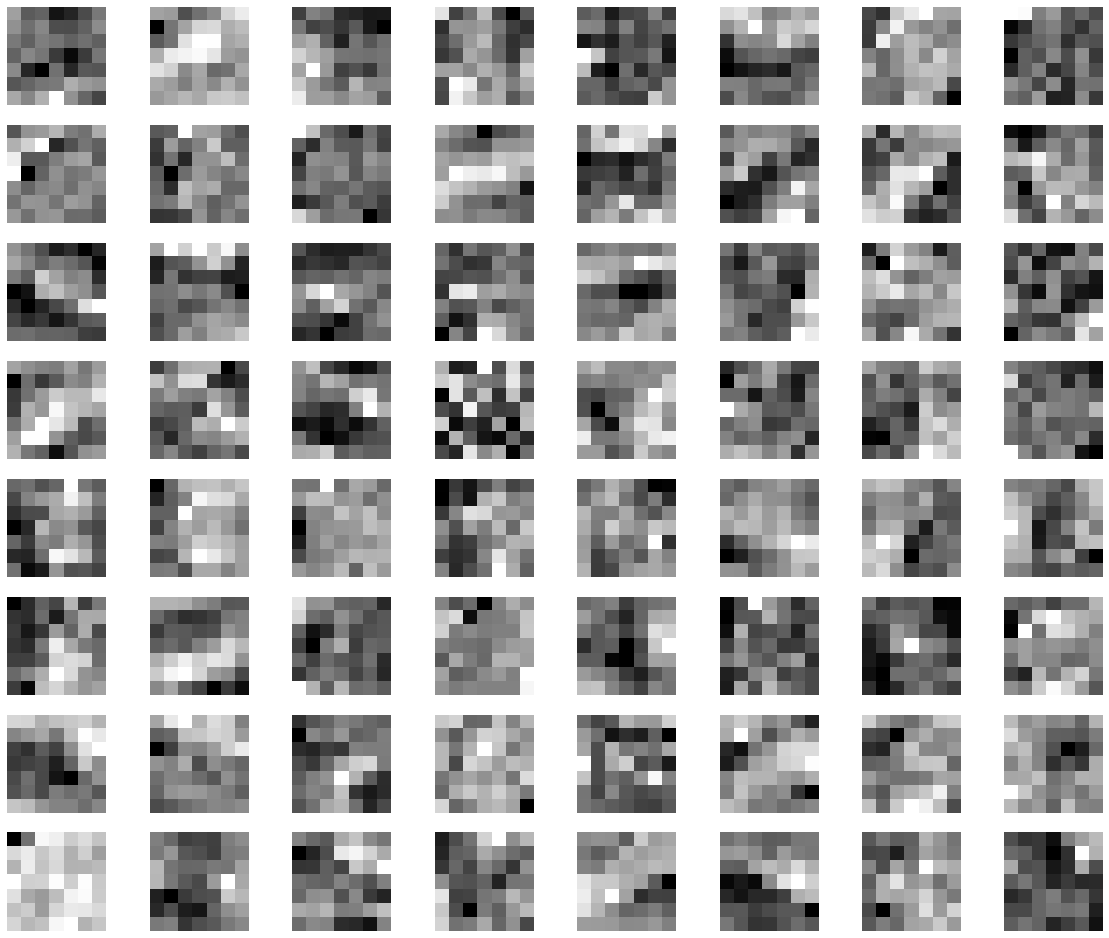

In [ ]:
# take a look at the conv layers and the respective weights
for weight, conv in zip(model_weights, conv_layers):
    # print(f"WEIGHT: {weight} \nSHAPE: {weight.shape}")
    print(f"CONV: {conv} ====> SHAPE: {weight.shape}")# visualize the first conv layer filters
plt.figure(figsize=(20, 17))
for i, filter in enumerate(model_weights[0]):
    plt.subplot(8, 8, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    plt.imshow(filter[0, :, :].detach(), cmap='gray')
    plt.axis('off')
plt.show()